## Installing Necessary Libraries

In [1]:
!pip install imblearn
!pip install afinn
!pip install textblob
!pip install autonlp
!pip install autoviml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 KB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=c133942a3133f9b6dd1d363ca6d529f49cfb97f596fa3fc50de546657ec59441
  Stored in directory: /root/.cache/pip/wheels/79/91/ee/8374d9bc8c6c0896a2db75afdfd63d43653902407a0e76cd94
Successfully built afinn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

## Import Libraries

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

## Importing Dataset

In [3]:
df = pd.read_csv("Amazon_Product_Reviews.csv")
df.head()

,Unnamed: 0,date,title,rating,body,model
0,0,4 May 2019,"Platina on, Garmi gone! Efficient cooler for n...",4.0,Summer and air cooler goes synonymously. As te...,Old Model
1,1,6 March 2023,Noise level,4.0,"Overall product is great , at this price you c...",New Model
2,2,22 March 2023,Superb,4.0,Very good product ☺️ superrrr,New Model
3,3,22 March 2023,OK,4.0,this product is good it is bajaj one.,New Model
4,4,19 March 2023,"Im okey with this, never loose your Money",4.0,The media could not be loaded.\n ...,New Model


In [4]:
# removing the columns that are not needed
df = df.drop('Unnamed: 0', axis=1)
df

,date,title,rating,body,model
0,4 May 2019,"Platina on, Garmi gone! Efficient cooler for n...",4.0,Summer and air cooler goes synonymously. As te...,Old Model
1,6 March 2023,Noise level,4.0,"Overall product is great , at this price you c...",New Model
2,22 March 2023,Superb,4.0,Very good product ☺️ superrrr,New Model
3,22 March 2023,OK,4.0,this product is good it is bajaj one.,New Model
4,19 March 2023,"Im okey with this, never loose your Money",4.0,The media could not be loaded.\n ...,New Model
...,...,...,...,...,...
4995,13 May 2019,Want to replace,1.0,It smells badly.want to replace,Old Model
4996,24 July 2019,Not Completely,1.0,Water💧 capacity low,Old Model
4997,17 June 2019,Dont buy this cooler,1.0,Dont buy this product..,Old Model
4998,26 March 2019,Waste of money,1.0,It is best very small room,Old Model


In [5]:
df.isna().sum()

date       0
title      1
rating     0
body      65
model      0
dtype: int64

In [6]:
df.isnull().sum()

date       0
title      1
rating     0
body      65
model      0
dtype: int64

In [7]:
df.dtypes

date       object
title      object
rating    float64
body       object
model      object
dtype: object

In [8]:
df = df.dropna(subset=['title', 'body'])

## Data Pre Processing

- 1. Converting all text to lowercase
- 2. Removing any special characters or punctuation marks
- 3. Tokenizing the text into individual words
- 4. Removing stop words
- 5. Stemming or lemmatizing the words to their root form
- 6. Separating the positive and negative words list

In [9]:
#Combining the title and body columns to create a single text column that we will use for your NLP analysis

import pandas as pd

# assuming your DataFrame is called 'df'
df['text'] = df['title'] + ' ' + df['body']

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in df['text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

In [11]:
data = df['text']
data

0       Platina on, Garmi gone! Efficient cooler for n...
1       Noise level Overall product is great , at this...
2                    Superb Very good product ☺️ superrrr
3                OK this product is good it is bajaj one.
4       Im okey with this, never loose your Money The ...
                              ...                        
4995      Want to replace It smells badly.want to replace
4996                   Not Completely Water💧 capacity low
4997         Dont buy this cooler Dont buy this product..
4998            Waste of money It is best very small room
4999    Bad quality product Bad quality product with t...
Name: text, Length: 4935, dtype: object

### Converting all Text to Lower Case

In [12]:
data = df['text'].apply(lambda x: x.lower())
data

0       platina on, garmi gone! efficient cooler for n...
1       noise level overall product is great , at this...
2                    superb very good product ☺️ superrrr
3                ok this product is good it is bajaj one.
4       im okey with this, never loose your money the ...
                              ...                        
4995      want to replace it smells badly.want to replace
4996                   not completely water💧 capacity low
4997         dont buy this cooler dont buy this product..
4998            waste of money it is best very small room
4999    bad quality product bad quality product with t...
Name: text, Length: 4935, dtype: object

### Removing any special characters or punctuation marks

In [13]:
import re

# Remove special characters and punctuation
def remove_special_chars(text):
    # Remove special characters
    text = re.sub('[^a-zA-Z0-9\s]', '', text)

    # Remove punctuation
    text = re.sub('[^\w\s]', '', text)

    return text

In [14]:
data = data.apply(remove_special_chars)
data

0       platina on garmi gone efficient cooler for nor...
1       noise level overall product is great  at this ...
2                      superb very good product  superrrr
3                 ok this product is good it is bajaj one
4       im okey with this never loose your money the m...
                              ...                        
4995       want to replace it smells badlywant to replace
4996                    not completely water capacity low
4997           dont buy this cooler dont buy this product
4998            waste of money it is best very small room
4999    bad quality product bad quality product with t...
Name: text, Length: 4935, dtype: object

### Removing links (http | https)

In [15]:
import pandas as pd

# assuming 'data' is a Series object
df = data.to_frame()

for index, row in df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.text.split() if 'http' not in word]
    df.at[index, 'text'] = ' '.join(words_without_links)

print(df.head())

                                                text
0  platina on garmi gone efficient cooler for nor...
1  noise level overall product is great at this p...
2                  superb very good product superrrr
3            ok this product is good it is bajaj one
4  im okey with this never loose your money the m...


In [16]:
data = pd.Series(df['text'].values, index=df.index)
data

0       platina on garmi gone efficient cooler for nor...
1       noise level overall product is great at this p...
2                       superb very good product superrrr
3                 ok this product is good it is bajaj one
4       im okey with this never loose your money the m...
                              ...                        
4995       want to replace it smells badlywant to replace
4996                    not completely water capacity low
4997           dont buy this cooler dont buy this product
4998            waste of money it is best very small room
4999    bad quality product bad quality product with t...
Length: 4935, dtype: object

### Tokenizing the text into individual word and Removing Stopwords

- Tokenization is the process of breaking down a piece of text into individual words, phrases, or other meaningful elements, which are called tokens. The goal of tokenization is to create a structured and standardized representation of text data that can be easily analyzed and processed by machines.

- Stop words are words that are commonly used in a language but do not contribute much to the meaning of a sentence. Examples of stop words include "a," "an," "the," "in," "on," and "at." Removing stop words from text data is a common pre-processing step in natural language processing (NLP) tasks, such as text classification, sentiment analysis, and topic modeling. The idea behind removing stop words is to reduce noise in the data and improve the accuracy of NLP models.

In [17]:
import nltk
nltk.download('punkt')

# download stopwords
nltk.download('stopwords')

# import stopwords and word_tokenize from NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# create a list of stopwords
stop_words = set(stopwords.words('english'))

# tokenize the text column into individual words
data = data.apply(lambda x: word_tokenize(x))

# remove stopwords
tokenized_data = data.apply(lambda x: [word for word in x if word not in stop_words])
tokenized_data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0       [platina, garmi, gone, efficient, cooler, norm...
1       [noise, level, overall, product, great, price,...
2                       [superb, good, product, superrrr]
3                         [ok, product, good, bajaj, one]
4       [im, okey, never, loose, money, media, could, ...
                              ...                        
4995          [want, replace, smells, badlywant, replace]
4996                   [completely, water, capacity, low]
4997              [dont, buy, cooler, dont, buy, product]
4998                    [waste, money, best, small, room]
4999    [bad, quality, product, bad, quality, product,...
Length: 4935, dtype: object

### Lemmatization

Lemmatization, is a process of reducing a word to its base or dictionary form, known as the lemma. For example, "running", "runs", and "run" would all be lemmatized to "run". Lemmatization is a more sophisticated method that takes into account the context of the word and can produce meaningful words, but it is slower and more complex than stemming.

In [18]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

# create a lemmatizer object
lemmatizer = WordNetLemmatizer()

# apply lemmatizing to each word in the data
lematized_data = tokenized_data.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
lematized_data

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


0       [platina, garmi, gone, efficient, cooler, norm...
1       [noise, level, overall, product, great, price,...
2                       [superb, good, product, superrrr]
3                         [ok, product, good, bajaj, one]
4       [im, okey, never, loose, money, medium, could,...
                              ...                        
4995           [want, replace, smell, badlywant, replace]
4996                   [completely, water, capacity, low]
4997              [dont, buy, cooler, dont, buy, product]
4998                    [waste, money, best, small, room]
4999    [bad, quality, product, bad, quality, product,...
Length: 4935, dtype: object

## Inspecting common words

### Separating the positive and negative words list

In [19]:
from afinn import Afinn

# initialize Afinn
af = Afinn()

# initialize lists to store sentiment scores and sentiment categories
sentiment_scores = []
sentiment_categories = []

# iterate over each review and calculate its sentiment score
for review in lematized_data:
    if isinstance(review, list):  # check if review is a list
        review = ' '.join(review)  # join list of words into a single string
    sentiment_score = af.score(review)
    sentiment_scores.append(sentiment_score)
    
    # classify each review as positive, negative, or neutral based on its sentiment score
    if sentiment_score > 0:
        sentiment_categories.append('positive')
    elif sentiment_score < 0:
        sentiment_categories.append('negative')
    else:
        sentiment_categories.append('neutral')

# count number of reviews in each sentiment category
positive_count = sentiment_categories.count('positive')
negative_count = sentiment_categories.count('negative')
neutral_count = sentiment_categories.count('neutral')

# print results
print('Positive reviews:', positive_count)
print('Negative reviews:', negative_count)
print('Neutral reviews:', neutral_count)

Positive reviews: 3419
Negative reviews: 897
Neutral reviews: 619


In [20]:
from nltk.probability import FreqDist

# Assuming lemmatized_tokens is a list of lemmatized tokens
flattened_tokens = [token for sublist in lematized_data for token in sublist]

fdist = FreqDist(flattened_tokens)

# Print the most common words
print(fdist.most_common(50))

[('good', 2985), ('product', 2636), ('cooler', 1883), ('water', 975), ('small', 947), ('cooling', 936), ('room', 884), ('nice', 743), ('air', 741), ('quality', 624), ('money', 599), ('one', 576), ('buy', 572), ('fan', 567), ('working', 566), ('noise', 530), ('dont', 458), ('bad', 454), ('bajaj', 414), ('price', 407), ('best', 387), ('cool', 384), ('like', 380), ('month', 371), ('size', 364), ('day', 357), ('worst', 355), ('low', 328), ('use', 327), ('worth', 313), ('wheel', 312), ('medium', 299), ('waste', 293), ('ok', 286), ('amazon', 278), ('could', 271), ('level', 269), ('2', 269), ('also', 259), ('person', 255), ('motor', 246), ('better', 241), ('pump', 237), ('go', 231), ('speed', 231), ('much', 224), ('value', 222), ('work', 222), ('even', 220), ('le', 219)]


In [21]:
# initialize empty lists for positive, negative, and neutral words
positive_words = []
negative_words = []
neutral_words = []

# iterate over each review and extract its sentiment
for review, sentiment in zip(lematized_data, sentiment_scores):
    # classify each review as positive, negative, or neutral based on its sentiment score
    if sentiment > 0:
        positive_words += review
    elif sentiment < 0:
        negative_words += review
    else:
        neutral_words += review

# count the frequency of each word in each sentiment category
from collections import Counter
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)
neutral_word_counts = Counter(neutral_words)

# print the most common words in each sentiment category
print("Most common positive words:")
print(positive_word_counts.most_common(10))
print("\nMost common negative words:")
print(negative_word_counts.most_common(10))
print("\nMost common neutral words:")
print(neutral_word_counts.most_common(10))

Most common positive words:
[('good', 2914), ('product', 1841), ('cooler', 1406), ('room', 779), ('nice', 738), ('small', 698), ('cooling', 679), ('water', 647), ('air', 566), ('fan', 494)]

Most common negative words:
[('product', 635), ('cooler', 335), ('bad', 321), ('worst', 303), ('water', 238), ('dont', 209), ('working', 204), ('buy', 203), ('waste', 186), ('money', 162)]

Most common neutral words:
[('product', 160), ('small', 154), ('cooler', 142), ('cooling', 105), ('ok', 103), ('working', 94), ('water', 90), ('size', 74), ('one', 67), ('average', 63)]


## Text feature extraction
Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.

We call vectorization the general process of turning a collection of text documents into numerical feature vectors.

### Using TF-IDF to weight the importance of each word in the bag-of-words representation

- TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a numerical statistic that is used to reflect how important a word is in a document or a corpus (collection of documents) based on how frequently it appears in the document or corpus and how common or rare it is in the corpus.

- TF (Term Frequency) measures the frequency of a word in a document. It is calculated as the number of times a word appears in a document divided by the total number of words in the document.

- IDF (Inverse Document Frequency) measures how important a word is across the entire corpus. It is calculated as the logarithm of the total number of documents in the corpus divided by the number of documents that contain the word.

- TF-IDF is calculated by multiplying the TF and IDF values for each word. It assigns a high weight to words that are frequent in a document but rare in the corpus, and a low weight to words that are frequent in both the document and the corpus.

In [22]:
# join the lists of lemmatized words for each document into a single string
lm_data = lematized_data.apply(lambda x: ' '.join(x))

# create a TfidfVectorizer object
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1500, min_df=8, stop_words='english')

# fit the vectorizer to the preprocessed data
vectorizer.fit(lm_data)

# create TF-IDF vectors for the preprocessed data
tfidf_vectors = vectorizer.transform(lm_data)

# print the shape of the TF-IDF matrix
print(tfidf_vectors.shape)

(4935, 743)


In [23]:
vectorizer.vocabulary_

{'gone': 270,
 'efficient': 215,
 'cooler': 152,
 'normal': 441,
 'sized': 602,
 'room': 565,
 'review': 563,
 'summer': 640,
 'air': 39,
 'temperature': 657,
 'went': 719,
 'need': 429,
 'earlier': 209,
 'bad': 55,
 'season': 580,
 'waiting': 706,
 'model': 413,
 'manufacturer': 387,
 'like': 360,
 'symphony': 648,
 'price': 500,
 'point': 486,
 'feature': 242,
 'bajaj': 57,
 'similar': 595,
 'range': 523,
 'product': 503,
 'company': 133,
 'budget': 85,
 'strong': 631,
 'box': 77,
 'manual': 385,
 'warranty': 708,
 'good': 271,
 'looking': 371,
 'quality': 519,
 'effective': 213,
 'cooling': 153,
 'size': 601,
 'honeycomb': 302,
 'type': 688,
 'pad': 461,
 'castor': 100,
 'wheel': 721,
 'easy': 211,
 'noise': 437,
 'level': 356,
 'acceptable': 30,
 'capacity': 95,
 'water': 712,
 'tank': 651,
 'single': 598,
 '12': 4,
 'hour': 307,
 'continuous': 147,
 'swing': 646,
 'right': 564,
 'plastic': 481,
 'body': 75,
 'mean': 396,
 'issue': 334,
 'desert': 182,
 'start': 625,
 'leaking': 35

In [24]:
print("the type of count vectorizer ",type(tfidf_vectors))
print("the shape of out text TFIDF vectorizer ",tfidf_vectors.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_vectors.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4935, 743)
the number of unique words including both unigrams and bigrams  743


## Splitting Dataset Using Train Test Split

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#create a new DataFrame with the preprocessed data and sentiment labels
# create X and y DataFrames
X = pd.DataFrame(tfidf_vectors.toarray(), columns=vectorizer.get_feature_names_out())
y = pd.DataFrame(sentiment_categories, columns=['sentiment'])

# encode the sentiment labels as integers
le = LabelEncoder()
y = le.fit_transform(sentiment_categories)

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print the shapes of the train and test sets
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (3948, 743)
Test set shape: (987, 743)


## Balancing Reviews 

## Using SMOTE (Synthetic Minority Over-sampling Technique)
 We use three different methods to balance the number of positive and negative reviews:

- RandomOverSampler: increases the number of minority class samples by randomly replicating them.
- RandomUnderSampler: decreases the number of majority class samples by randomly removing some of them.
- SMOTE: creates synthetic samples for the minority class by interpolating between existing samples.

SMOTE (Synthetic Minority Over-sampling Technique) is a method for oversampling imbalanced data, where the minority class is under-represented compared to the majority class. It works by generating synthetic examples for the minority class based on the existing examples, in order to balance the class distribution.

In [26]:
from imblearn.over_sampling import SMOTE

In [27]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Resample training data using SMOTE
smote = SMOTE()
x_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Resample test data using SMOTE
x_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7fca9087f820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.9/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.9/dist-packages/numpy.libs/libopenblas64_p-r0-2f7c42d4.3.18.so: cannot open shar

In [28]:
import pandas as pd

# Convert resampled target vector to pandas Series
y_train_resampled_series = pd.Series(y_train_resampled)

# Check distribution of classes in resampled data
print(y_train_resampled_series.value_counts())


1    2758
0    2758
2    2758
dtype: int64


In [29]:
import pandas as pd

# Convert resampled target vector to pandas Series
y_test_resampled_series = pd.Series(y_test_resampled)

# Check distribution of classes in resampled data
print(y_test_resampled_series.value_counts())


0    661
1    661
2    661
dtype: int64


In [30]:
print(x_train_resampled.shape)

(8274, 743)


In [31]:
x_train_resampled.head(10)

,10,100,1010,10x10,12,15,150,1st,20,2020,...,worth,worthless,worthy,writing,wrong,wrost,year,yes,youre,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.515312
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [32]:
print(x_test_resampled.shape)

(1983, 743)


## Tsne

In [33]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Define the number of top features to select
k = 100

# Initialize SelectKBest with the mutual information scoring function
selector = SelectKBest(mutual_info_classif, k=k)

# Fit the selector on the training data and transform both the training and test data
x_train_selected = selector.fit_transform(x_train_resampled, y_train_resampled)
x_test_selected = selector.transform(x_test_resampled)


In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

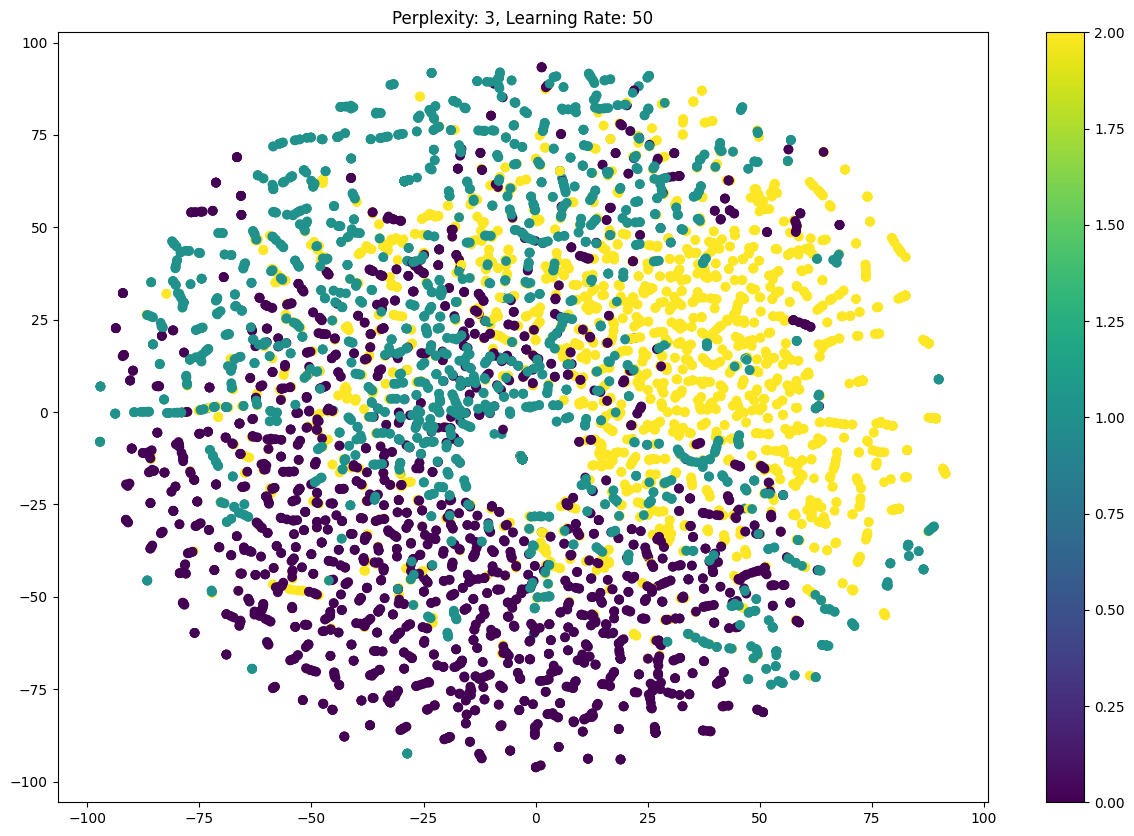

In [35]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Initialize t-SNE with the desired parameter combination
tsne = TSNE(n_components=2, perplexity=3, learning_rate=50, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_selected)

# Plot the resulting embeddings
plt.figure(figsize=(15,10))
plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], c=y_train_resampled, cmap='viridis')
plt.title(f"Perplexity: 3, Learning Rate: 50")
plt.colorbar()
plt.show()

# Model Building

## Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define logistic regression model
lr = LogisticRegression()

# Define hyperparameter grid
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'multi_class': ['ovr', 'multinomial']
}

# Perform grid search with 5-fold cross validation
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5)
grid_search_lr.fit(x_train_resampled, y_train_resampled)

# Print best hyperparameters and score
print("Best hyperparameters: ", grid_search_lr.best_params_)
print("Best validation score: ", grid_search_lr.best_score_)


Best hyperparameters:  {'C': 10, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
Best validation score:  0.9581823429057816


In [37]:
# Create logistic regression model with best hyperparameters
lr_model = LogisticRegression(**grid_search_lr.best_params_)

# Fit model to data
lr_model.fit(x_train_resampled, y_train_resampled)

# Make predictions on test data
y_pred_lr = lr_model.predict(x_test_resampled)
y_pred_lr

array([0, 1, 2, ..., 1, 1, 1])

[[596  26  39]
 [ 69 573  19]
 [ 17  12 632]]


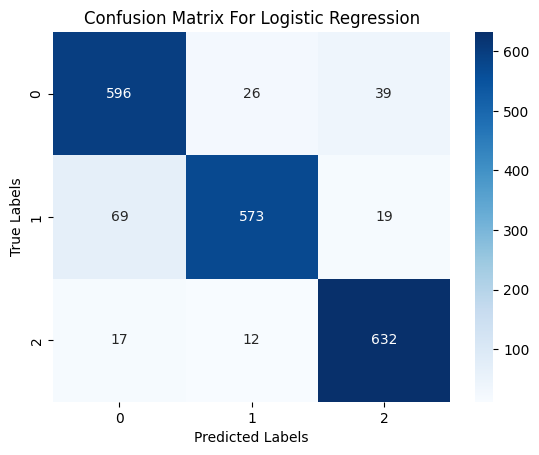

In [38]:
# for a 3-class classification problem
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# compute confusion matrix
cm_lr = confusion_matrix(y_test_resampled, y_pred_lr)

# print confusion matrix
print(cm_lr)

# create heatmap
sns.heatmap(cm_lr, annot=True, cmap="Blues", fmt='d')

# add axis labels
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix For Logistic Regression")

# display plot
plt.show()

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test_resampled, y_pred_lr))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       661
           1       0.94      0.87      0.90       661
           2       0.92      0.96      0.94       661

    accuracy                           0.91      1983
   macro avg       0.91      0.91      0.91      1983
weighted avg       0.91      0.91      0.91      1983



In [40]:
from sklearn.metrics import accuracy_score

lr_accuracy = accuracy_score(y_test_resampled, y_pred_lr)
print("Accuracy:", lr_accuracy)

Accuracy: 0.908219868885527


## Support Vector Machine

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the SVM model
svm = SVC()

# Define the hyperparameters to search over
param_grid_svm = {'C': [1, 10],
              'kernel': ['linear', 'rbf'],
              'gamma': ['scale']}

# Define the grid search using Ray Tune
grid_search_svm = GridSearchCV(svm, param_grid = param_grid_svm, cv=3, n_jobs=-1)

# Fit the grid search to the data
grid_search_svm.fit(x_train_resampled, y_train_resampled)

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search_svm.best_params_)
print("Best validation score: ", grid_search_svm.best_score_)

Best hyperparameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best validation score:  0.9546773023930385


In [42]:
# Create an SVM model with the best hyperparameters
svm_model = SVC(**grid_search_svm.best_params_)

# Fit the model to the data
svm_model.fit(x_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_svm = svm_model.predict(x_test_resampled)
y_pred_svm

array([0, 1, 2, ..., 1, 1, 1])

[[591  37  33]
 [ 70 580  11]
 [ 23  16 622]]


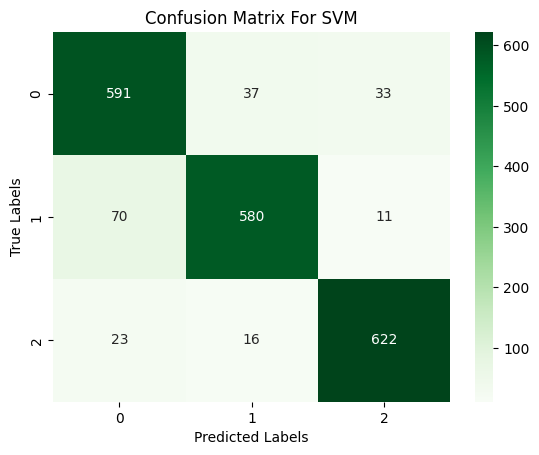

In [43]:
# for a 3-class classification problem
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# compute confusion matrix
cm_svm = confusion_matrix(y_test_resampled, y_pred_svm)

# print confusion matrix
print(cm_svm)

# create heatmap
sns.heatmap(cm_svm, annot=True, cmap="Greens", fmt='d')

# add axis labels
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix For SVM")

# display plot
plt.show()

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test_resampled, y_pred_svm))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       661
           1       0.92      0.88      0.90       661
           2       0.93      0.94      0.94       661

    accuracy                           0.90      1983
   macro avg       0.90      0.90      0.90      1983
weighted avg       0.90      0.90      0.90      1983



In [45]:
from sklearn.metrics import accuracy_score

svm_accuracy = accuracy_score(y_test_resampled, y_pred_svm)
print("Accuracy:", svm_accuracy)

Accuracy: 0.9041855774079677


## Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Create a decision tree classifier
dt_clf = DecisionTreeClassifier()

# Define the grid of hyperparameters to search over
params_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15,None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [2,4,6]
}

# Perform a grid search over the hyperparameters
dt_cv = GridSearchCV(dt_clf, param_grid=params_dt, cv=5, n_jobs=-1)

# Fit the model to the training data
dt_cv.fit(x_train_resampled, y_train_resampled)

# Print the best hyperparameters and validation score
print("Best hyperparameters: ", dt_cv.best_params_)
print("Best validation score: ", dt_cv.best_score_)


Best hyperparameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2}
Best validation score:  0.9208371539105054


In [47]:
# Create an SVM model with the best hyperparameters
dt_model = DecisionTreeClassifier(**dt_cv.best_params_)

# Fit the model to the data
dt_model.fit(x_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_dt = dt_model.predict(x_test_resampled)
y_pred_dt

array([0, 0, 2, ..., 0, 0, 1])

[[582  30  49]
 [106 537  18]
 [ 45  28 588]]


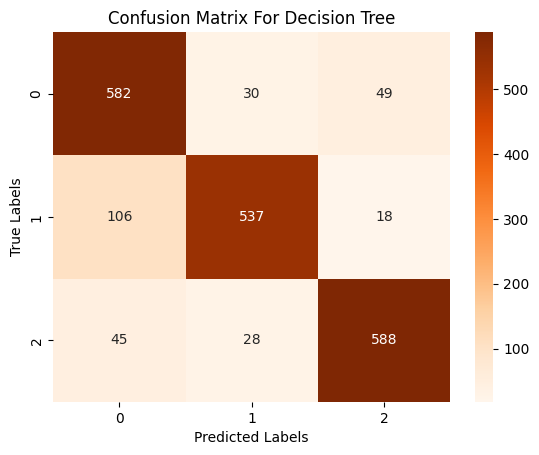

In [48]:
# for a 3-class classification problem
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# compute confusion matrix
cm_dt = confusion_matrix(y_test_resampled, y_pred_dt)

# print confusion matrix
print(cm_dt)

# create heatmap
sns.heatmap(cm_dt, annot=True, cmap="Oranges", fmt='d')

# add axis labels
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix For Decision Tree")

# display plot
plt.show()

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test_resampled, y_pred_dt))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       661
           1       0.90      0.81      0.86       661
           2       0.90      0.89      0.89       661

    accuracy                           0.86      1983
   macro avg       0.86      0.86      0.86      1983
weighted avg       0.86      0.86      0.86      1983



In [50]:
from sklearn.metrics import accuracy_score

dt_accuracy = accuracy_score(y_test_resampled, y_pred_dt)
print("Accuracy:", dt_accuracy)

Accuracy: 0.8608169440242057


## Naive Bayes

In [51]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the grid of hyperparameters to search over
params_nb = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

# Create a Naive Bayes classifier
nb_clf = MultinomialNB()

# Perform a grid search over the hyperparameters
nb_cv = GridSearchCV(nb_clf, param_grid=params_nb, cv=5)

# Fit the model to the training data
nb_cv.fit(x_train_resampled, y_train_resampled)

# Print the best hyperparameters and validation score
print("Best hyperparameters: ", nb_cv.best_params_)
print("Best validation score: ", nb_cv.best_score_)


Best hyperparameters:  {'alpha': 0.1, 'fit_prior': True}
Best validation score:  0.8263245377862694


In [52]:
# Create an SVM model with the best hyperparameters
nb_model = MultinomialNB(**nb_cv.best_params_)

# Fit the model to the data
nb_model.fit(x_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_nb = nb_model.predict(x_test_resampled)
y_pred_nb

array([1, 0, 2, ..., 2, 0, 0])

[[575  39  47]
 [193 313 155]
 [ 57  50 554]]


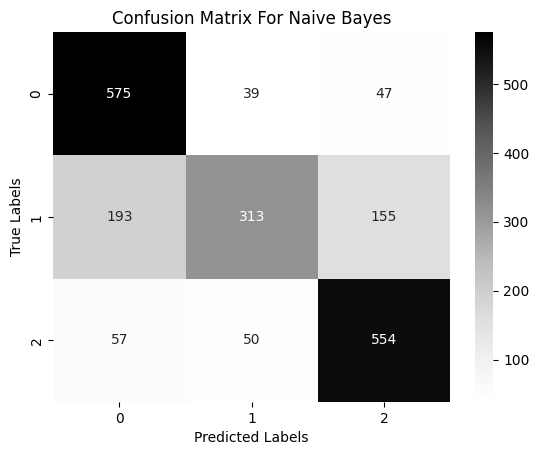

In [53]:
# for a 3-class classification problem
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# compute confusion matrix
cm_nb = confusion_matrix(y_test_resampled, y_pred_nb)

# print confusion matrix
print(cm_nb)

# create heatmap
sns.heatmap(cm_nb, annot=True, cmap="Greys", fmt='d')

# add axis labels
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix For Naive Bayes")

# display plot
plt.show()

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test_resampled, y_pred_nb))

              precision    recall  f1-score   support

           0       0.70      0.87      0.77       661
           1       0.78      0.47      0.59       661
           2       0.73      0.84      0.78       661

    accuracy                           0.73      1983
   macro avg       0.74      0.73      0.71      1983
weighted avg       0.74      0.73      0.71      1983



In [55]:
from sklearn.metrics import accuracy_score

nb_accuracy = accuracy_score(y_test_resampled, y_pred_nb)
print("Accuracy:", nb_accuracy)

Accuracy: 0.7271810388300555


## Neural Network

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Define the neural network architecture
nn_clf = Sequential()
nn_clf.add(Dense(64, activation='relu', input_dim=x_train_resampled.shape[1]))
nn_clf.add(Dense(1, activation='sigmoid'))

# Compile the model
nn_clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
nn_clf.fit(x_train_resampled, y_train_resampled, epochs=10)

# Make predictions on the test set
y_pred_nn_prob = nn_clf.predict(x_test_resampled)
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int)

# Define the neural network architecture
nn_clf = Sequential()
nn_clf.add(Dense(64, activation='relu', input_dim=x_train_resampled.shape[1]))
nn_clf.add(Dense(1, activation='sigmoid'))

# Compile the model
nn_clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
nn_clf.fit(x_train_resampled, y_train_resampled, epochs=10)

# Make predictions on the test set
y_pred_nn_prob = nn_clf.predict(x_test_resampled)
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int)


Epoch 1/10
259/259 [==============================] - 2s 3ms/step - loss: -0.1943 - accuracy: 0.3706
Epoch 2/10
259/259 [==============================] - 1s 3ms/step - loss: -3.6334 - accuracy: 0.4830
Epoch 3/10
259/259 [==============================] - 1s 3ms/step - loss: -10.3248 - accuracy: 0.4943
Epoch 4/10
259/259 [==============================] - 1s 3ms/step - loss: -20.2894 - accuracy: 0.4973
Epoch 5/10
259/259 [==============================] - 1s 3ms/step - loss: -33.2517 - accuracy: 0.4976
Epoch 6/10
259/259 [==============================] - 1s 4ms/step - loss: -48.8453 - accuracy: 0.4947
Epoch 7/10
259/259 [==============================] - 1s 4ms/step - loss: -66.9674 - accuracy: 0.4971
Epoch 8/10
259/259 [==============================] - 1s 4ms/step - loss: -87.3549 - accuracy: 0.4961
Epoch 9/10
259/259 [==============================] - 1s 4ms/step - loss: -109.9361 - accuracy: 0.4938
Epoch 10/10
62/62 [==============================] - 0s 2ms/step
Epoch 1/10
259/259

[[278 383   0]
 [  3 658   0]
 [  0 661   0]]


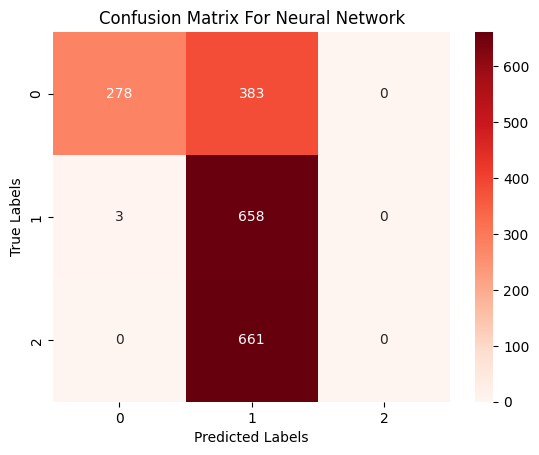

In [57]:
# for a 3-class classification problem
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# compute confusion matrix
cm_nn = confusion_matrix(y_test_resampled, y_pred_nn)

# print confusion matrix
print(cm_nn)

# create heatmap
sns.heatmap(cm_nn, annot=True, cmap="Reds", fmt='d')

# add axis labels
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix For Neural Network")

# display plot
plt.show()

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test_resampled, y_pred_nn))

              precision    recall  f1-score   support

           0       0.99      0.42      0.59       661
           1       0.39      1.00      0.56       661
           2       0.00      0.00      0.00       661

    accuracy                           0.47      1983
   macro avg       0.46      0.47      0.38      1983
weighted avg       0.46      0.47      0.38      1983



In [59]:
from sklearn.metrics import accuracy_score

nn_accuracy = accuracy_score(y_test_resampled, y_pred_nn)
print("Accuracy:", nn_accuracy)

Accuracy: 0.4720121028744327


## Auto NLP

In [60]:
pip install autoviml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
df['sentiment'] = sentiment_categories
df['sentiment_label'] = y

In [68]:
df

,text,sentiment,sentiment_label
0,platina on garmi gone efficient cooler for normal sized room review tips summer and air cooler goes synonymously as temperatures went above bearing limit there was need for cooler my earlier cooler went bad last season only so was waiting for another summeron one of my friends recommendations i selected it along with few other models from other manufacturers like symphony crompton etcupon subsequent analysis wrt price point features and utility bajaj platinic emerged on top from among similar range products from other companies budget may be one of the strong factors governing your inclinationinside box cooler manual warranty cardpros1 good looking lightweight portable2 good quality construction3 effective cooling for room size of 10x15ft4 honeycomb type cooling pads on three sides for effective cooling5 castor wheels 4nos for easy relocation6 noise levels are in acceptable range7 good capacity water tank single fill lasts for full 12 hours continuous usage8 auto swing ensures unif...,positive,2
1,noise level overall product is great at this price you couldnt get more coolingnormal water will have minimal cooling effect if u want more cooling can use cold waterthere is no option for ice chamber although it is mentioned in the user guideonly con that i see is noise level is little higher it was mentioned as similar to ceiling fan by couple of youtube reviews this could have been less then would have been 5 starwill use and edit the review after few months,positive,2
2,superb very good product superrrr,positive,2
3,ok this product is good it is bajaj one,positive,2
4,im okey with this never loose your money the media could not be loaded with this budget satisfied producing cool wind looking also good noise level is little high but not disturbed well packed and recently manufactured item delivered thanks,positive,2
...,...,...,...
4995,want to replace it smells badlywant to replace,positive,2
4996,not completely water capacity low,neutral,1
4997,dont buy this cooler dont buy this product,neutral,1
4998,waste of money it is best very small room,positive,2


In [69]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

In [70]:
from autoviml.Auto_NLP import Auto_NLP

In [71]:
input_feature, target = "text", "sentiment_label"

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

Auto NLP processing on NLP Column: text
Shape of Train Data: 3948 rows
    Shape of Test Data: 987 rows


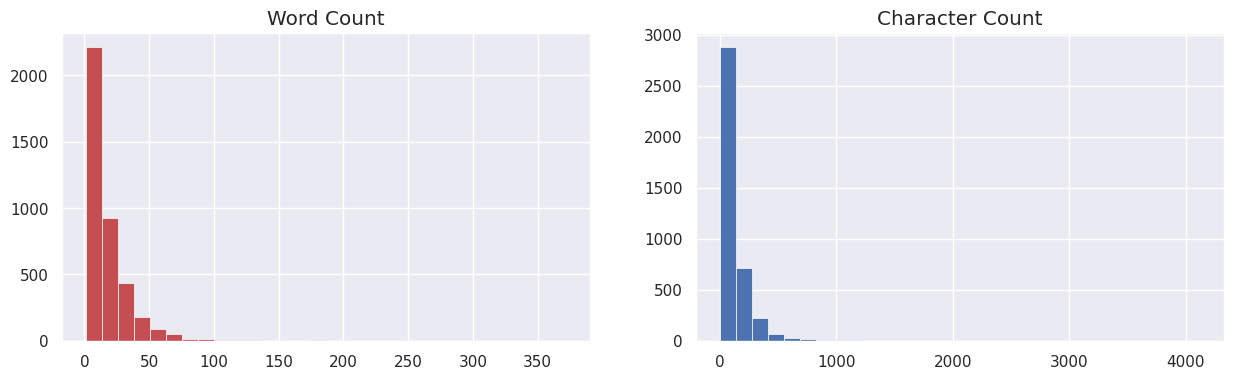

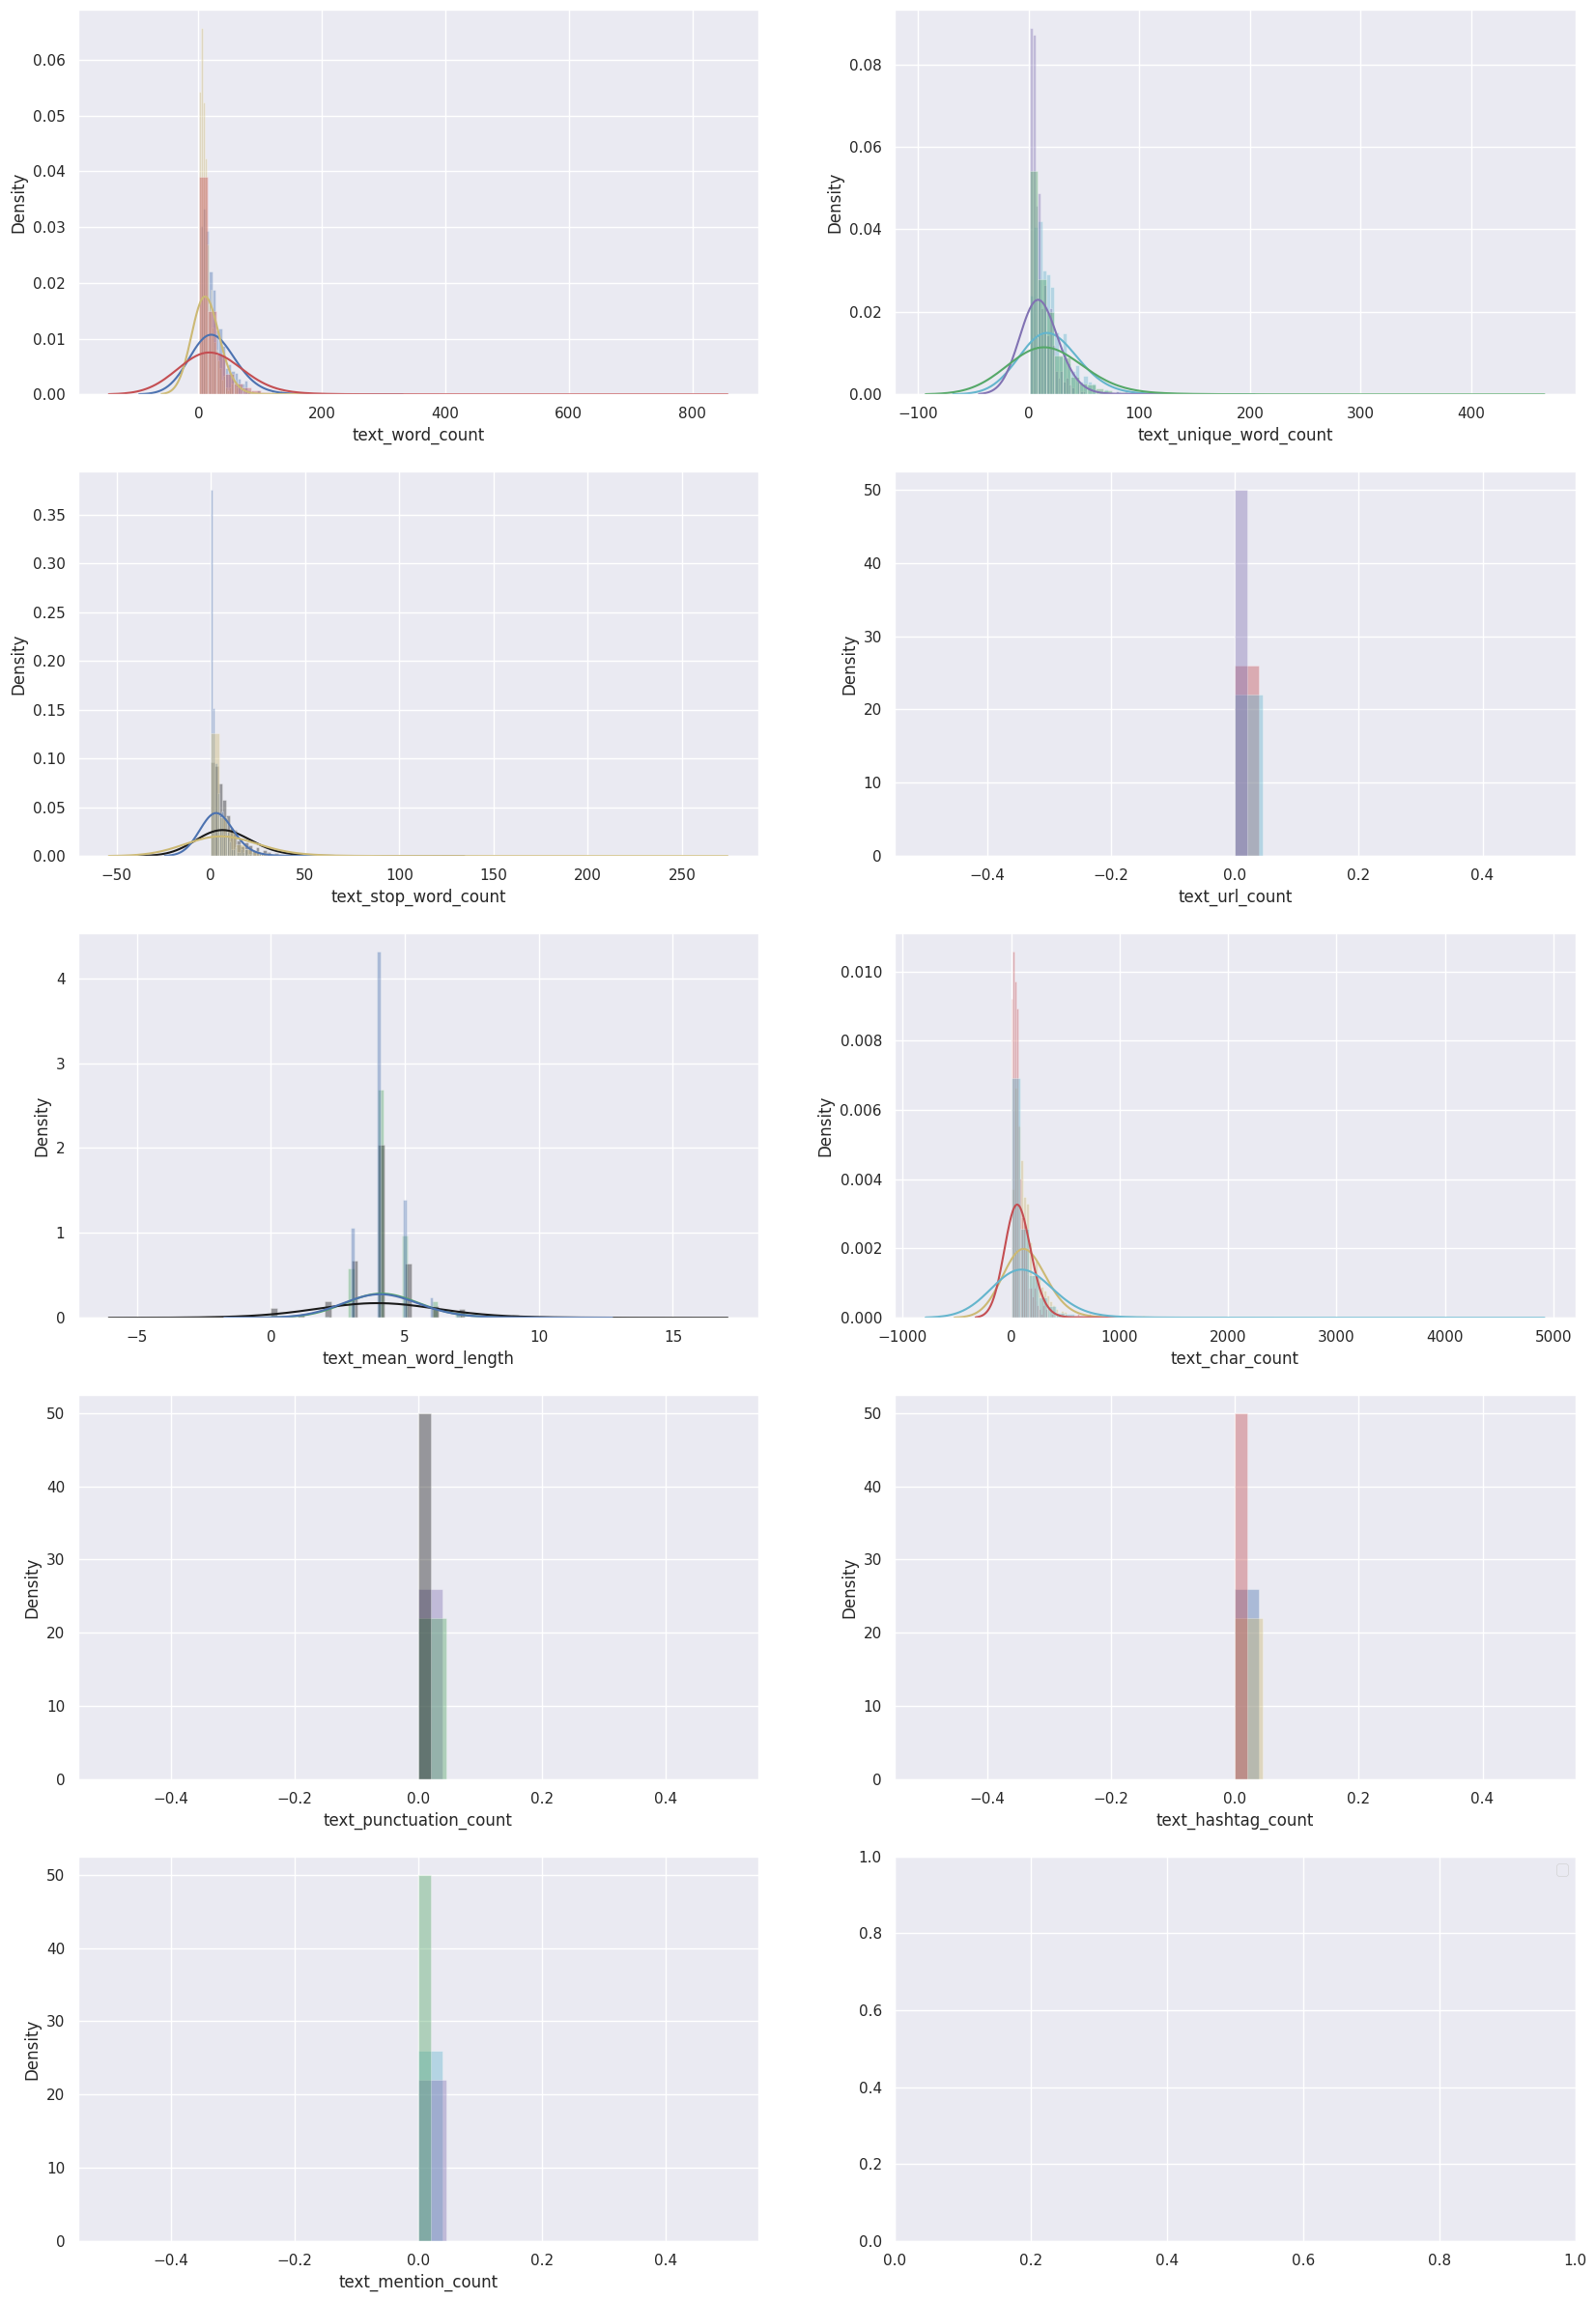

    Added 9 summary columns for counts of words and characters in each row
Cleaning text in Train data for text column
    Faster text processing using clean_tweets function, since top_num_features exceeds 300
Train data Text cleaning completed. Time taken = 9 seconds

For target = sentiment_label

    For class = 0
Top 200 n-grams
: ['product', 'bad', 'not', 'worst', 'buy', 'wast', 'dont', 'cooler', 'work', 'cool', 'money', 'water', 'month', 'poor', 'wheel', 'qualiti', 'after', 'stop', 'day', 'no', 'damag', 'small', 'use', 'air', 'pump', 'but', 'bajaj', 'broken', 'as', 'within', 'return', 'even', 'problem', 'servic', 'purchas', 'time', 'amazon', 'could', 'motor', 'load', 'come', 'defect', 'perform', 'fan', 'room', 'media', 'smell', 'nois', 'replac', 'like', 'low', 'week', 'ever', 'item', 'experi', 'will', 'disappoint', 'pleas', 'much', 'useless', 'expect', 'ok', 'go', 'receiv', 'properli', 'do', 'noisi', 'when', 'also', 'ha', 'there', 'good', 'dislik', 'they', 'now', 'your', 'flow', '

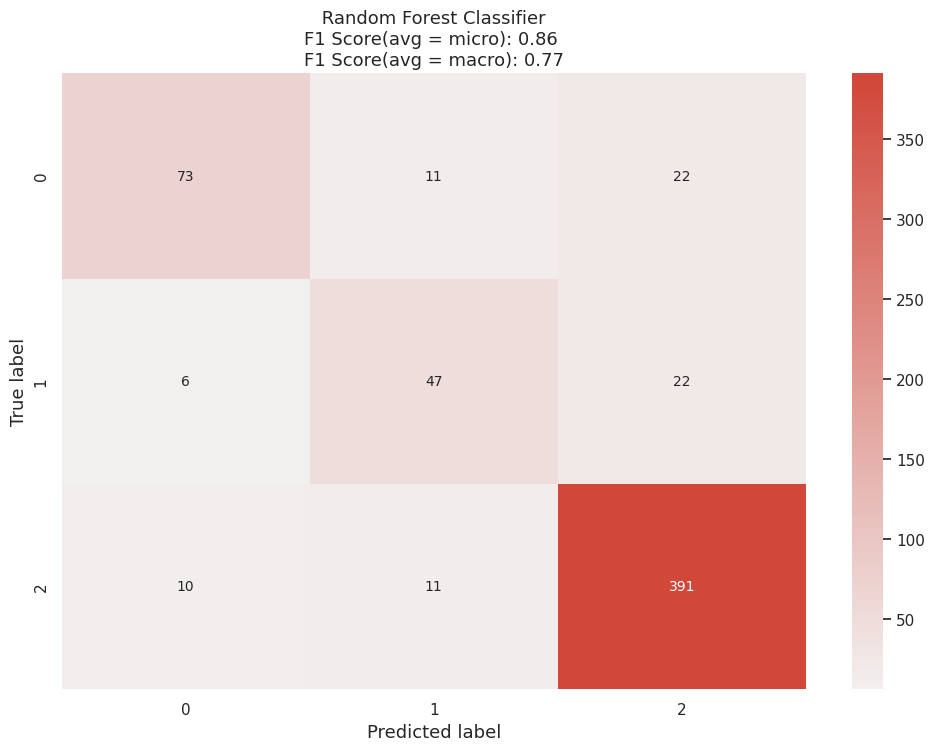

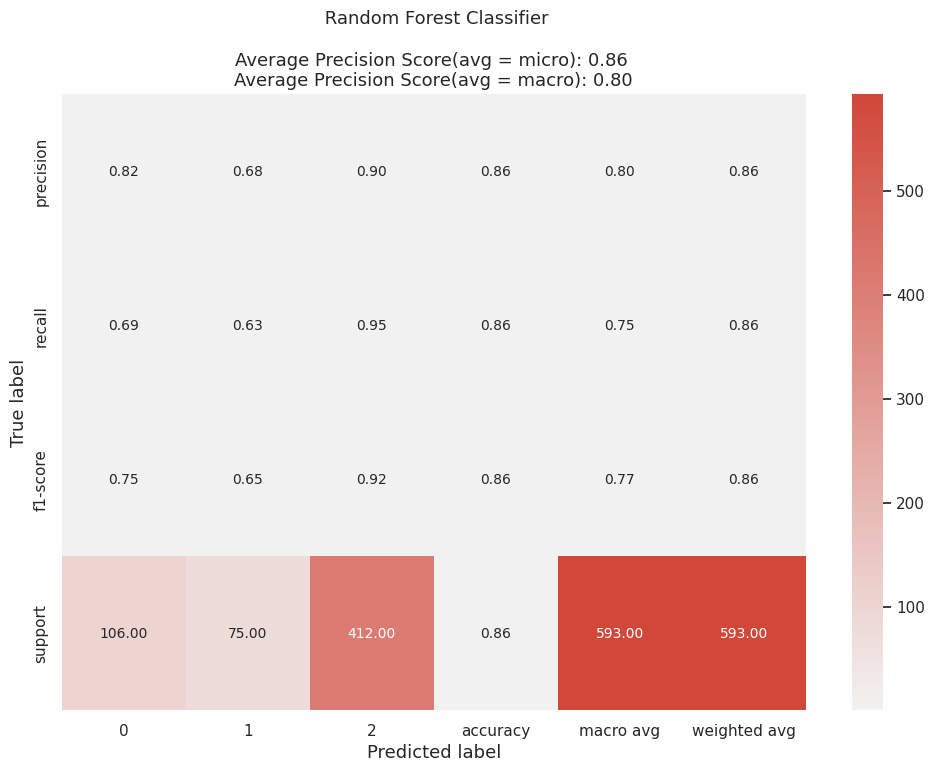

  Now transforming Train data to return as output...
  Transforming Test data to return as output...
Training best Auto_NLP Pipeline on full Train data...will be faster since best params are known
    Returning best Auto_NLP pipeline to transform and make predictions on test data...
Training completed. Time taken for Auto_NLP = 7.2 minutes


In [72]:
train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(input_feature, train_df, test_df, target, 
                                                          score_type='balanced_accuracy',
                                                          modeltype='Classification',
                                                          top_num_features=300, 
                                                          verbose=3,
                                                          build_model=True)

In [73]:
nlp_pipeline

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function Auto_NLP.<locals>.<lambda> at 0x7fca99e67430>)),
                ('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.9579799989390858, max_features=1241,
                                 min_df=2, ngram_range=(1, 3),
                                 sublinear_tf=True, token_pattern='\\w{1,}')),
                ('selectkbest',
                 SelectKBest(k=1241,
                             score_func=<function chi2 at 0x7fca90477040>)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=99))])

### Predicting For Test data

In [74]:
predicted_df_autoviml = test_df[['text','sentiment','sentiment_label']]

In [75]:
predicted_df_autoviml['Predicted_sentiment'] = nlp_pipeline.predict(test_df[input_feature])

In [76]:
predicted_df_autoviml.head()

,text,sentiment,sentiment_label,Predicted_sentiment
4052,bahut hi chota hai kuch kam ka nahin hai the media could not be loaded bahut hi chota hai kuch kam ka nahin hai,neutral,1,1
833,worth the price noise level a little on higher side everything else is great great cooling and air throw apt for midsummer,positive,2,2
2772,awesome awesome cooler at the price range of around 5000 rupees if set up with proper ventilation this cooler can be cooling heaven,positive,2,2
4184,good air cooler best one from bajaj two days once water load again for two full nights running,positive,2,2
1558,good cooler at this price good cooler at this price,positive,2,2


In [77]:
print(classification_report(predicted_df_autoviml['sentiment_label'],predicted_df_autoviml['Predicted_sentiment']))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       188
           1       0.68      0.65      0.66       122
           2       0.92      0.94      0.93       677

    accuracy                           0.87       987
   macro avg       0.79      0.78      0.79       987
weighted avg       0.86      0.87      0.87       987



In [78]:
ANLP_accuracy = accuracy_score(predicted_df_autoviml['sentiment_label'],predicted_df_autoviml['Predicted_sentiment'])
print("Accuracy:", ANLP_accuracy)

Accuracy: 0.8662613981762918


## Putting all Accuracies in One DataFrame

In [80]:
import pandas as pd

# Create a dictionary of model names and accuracy scores
accuracies = {
    "lr": lr_accuracy,
    "svm": svm_accuracy,
    "dt": dt_accuracy,
    "nb": nb_accuracy,
    "nn": nn_accuracy,
    "anlp": ANLP_accuracy
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(accuracies.items(), columns=["Model", "Accuracy"])

# Print the DataFrame
print(df)


  Model  Accuracy
0    lr      0.91
1   svm      0.90
2    dt      0.86
3    nb      0.73
4    nn      0.47
5  anlp      0.87
